In [5]:
import numpy as np
import pynbody
import matplotlib.pyplot as plt
import sys, os, glob, pickle, struct
import plot_tools
import make_plots
from scipy import stats
import add_obs
from pynbody.plot.stars import moster

In [2]:
def do_filter(a, b, lower_limit=1):
    """Filter two lists such that if one entry is invalid, both elements from the lists are removed."""
    
    def is_valid(elm):
        if elm is None:
            return False
        return elm > lower_limit and np.isfinite(elm)

    #print(len(b))
    for idx in range(len(b) - 1, -1, -1):
        #print(idx)
        if not is_valid(b[idx]) or not is_valid(a[idx]) :
            a = np.delete(a,idx)
            b = np.delete(b,idx)
    return a,b

def bin_stats(x, values):
    bin_means, bin_edges, binnumber = stats.binned_statistic(x, values, statistic='mean', bins=25)
    bin_std, bin_edges, binnumber = stats.binned_statistic(x, values, statistic='std', bins=25)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return bin_centers, bin_means, bin_std

def isInMoster(halo, z):
    y, yerr = moster(halo['mvir'], z)
    return float(y/yerr) <= float(halo['mstar']) <= float(y*yerr)

def loadClassify(pickle_path):
    def addToOutput(output, gal_dict):
        for key, value in output.items():
            try:
                value.append(gal_dict[str(key)])
            except:
                value.append(0)
                
    data = pickle.load( open( pickle_path , "rb" ))    
    good_output = dict([(str(k), []) for k in data[1]])
    fake_output = dict([(str(k), []) for k in data[1]])
        
    for gal_dict in data:
        if gal_dict is not None:
            if isInMoster(gal_dict, 0.2):
                addToOutput(good_output, gal_dict)
            else:
                gal_dict['mstar'], yerr = moster(gal_dict['mvir'], 0.2)
                addToOutput(fake_output, gal_dict)

                    
    for k, v in good_output.items():
        good_output[k] = np.array(v)
    for k, v in fake_output.items():
        fake_output[k] = np.array(v)
        
    return good_output, fake_output

path = "/scratch/hc2347/pickles/60/run0324.p"
entryReal, entryFalse = loadClassify(path)

In [3]:
path = "/scratch/hc2347/pickles/60/run0324.p"
entry = plot_tools.load_halos_pickle(path)

/home/hc2347/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


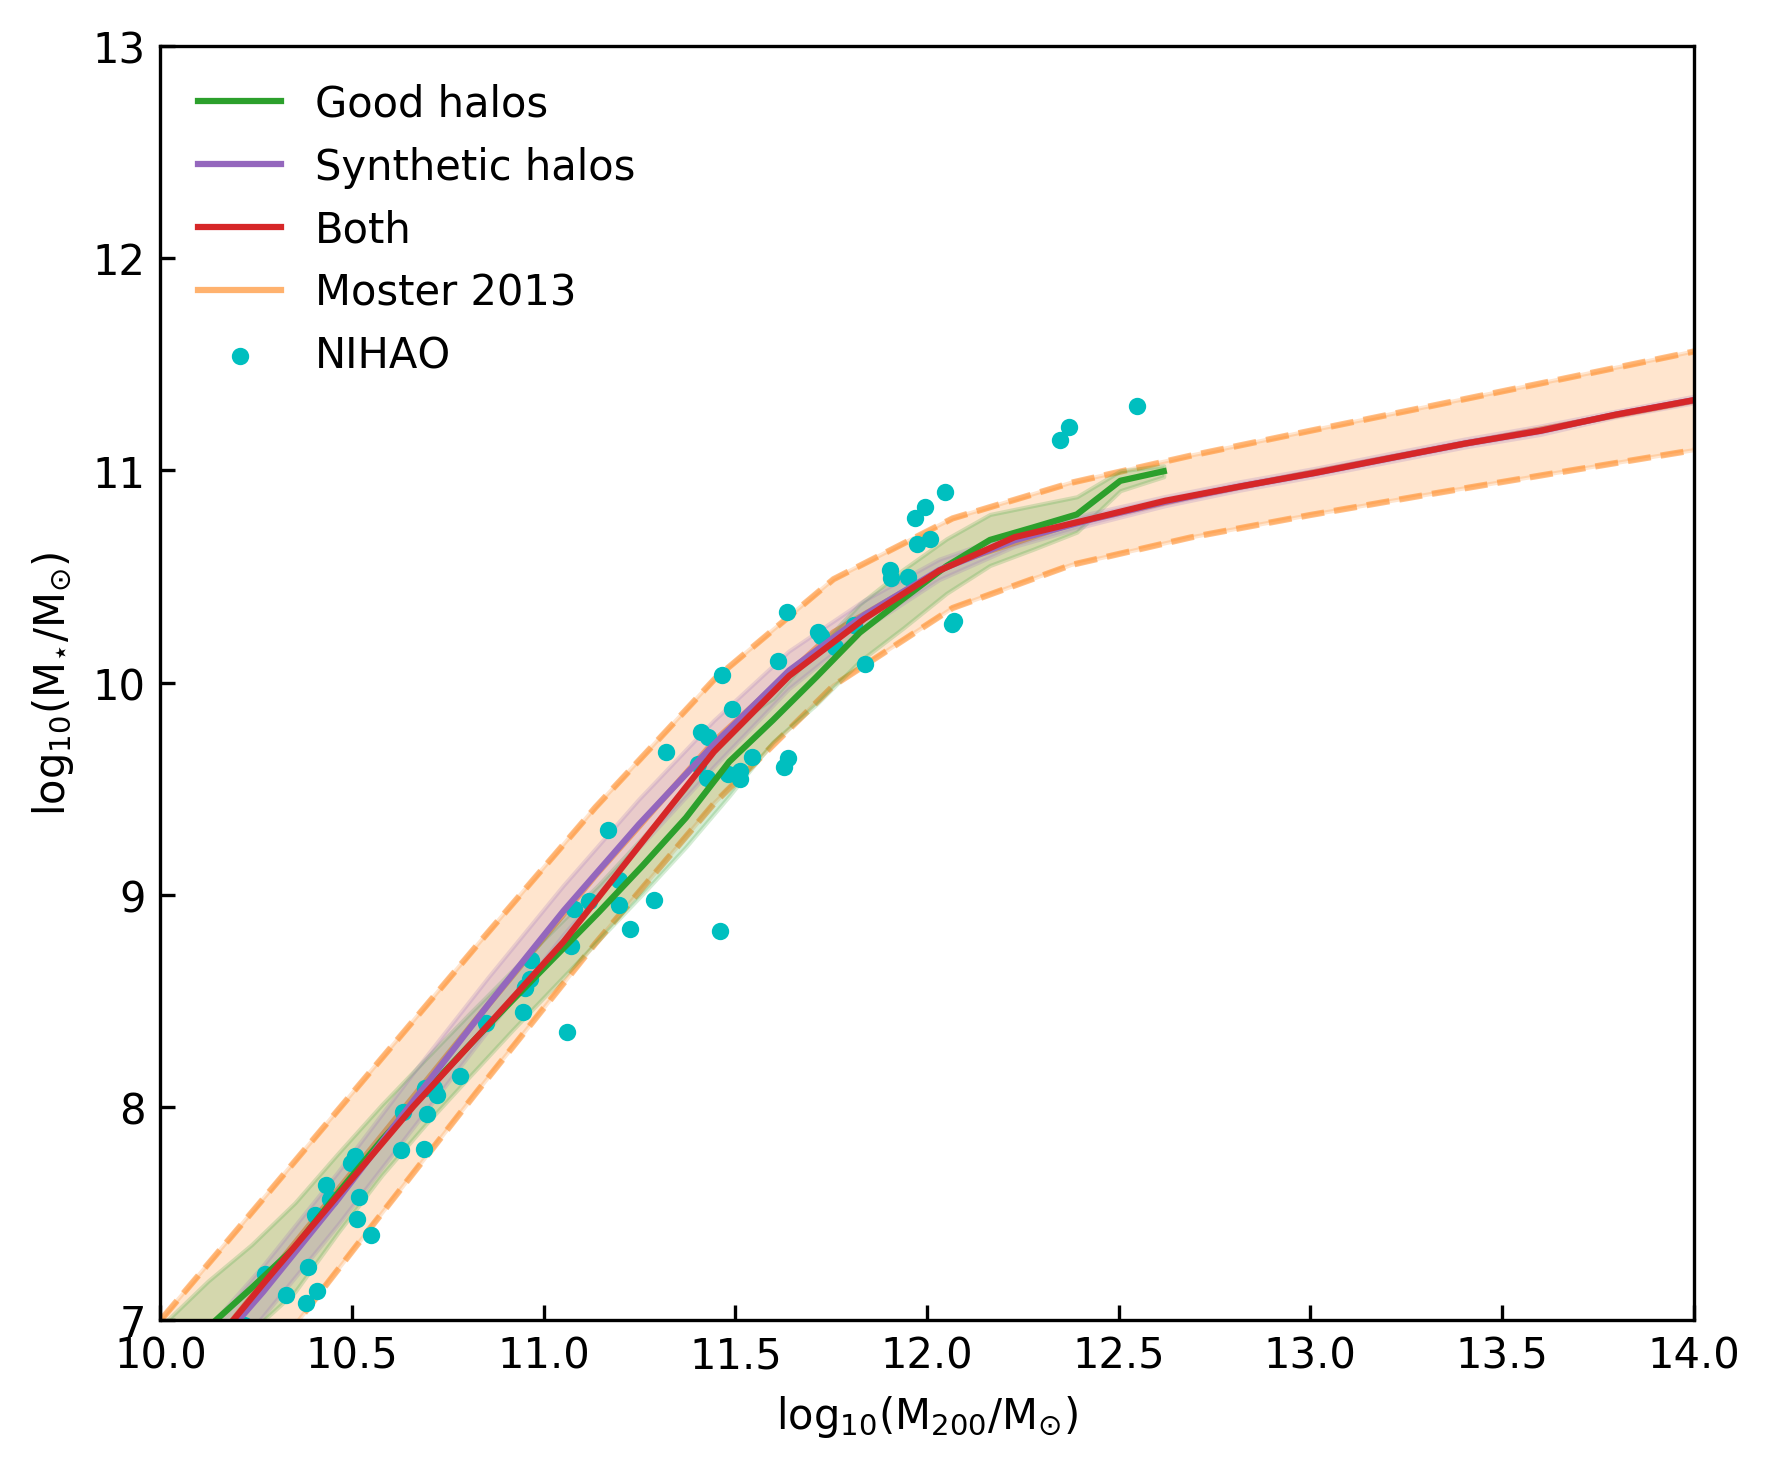

In [42]:
# --------------------------------
# ----- MOSTER -------------------
# --------------------------------
z = 0.2

def plotMoster(entry, color, label):
    x, y = do_filter(entry['mvir'], entry['mstar'], 1e-5)
    mc, mm, mstd = bin_stats(np.log10(x),np.log10(y))
    ax.plot(mc, mm, c=color, label = label)
    ax.fill_between(mc, mm + mstd, mm - mstd, color =color, alpha = 0.2)

fig, ax = plt.subplots(figsize=(6,5), dpi = 300)

# Only good halos
plotMoster(entryReal, "tab:green", "Good halos")
plotMoster(entryFalse, "tab:purple", "Synthetic halos")

# Both real and false combined
x = np.concatenate((entryReal['mvir'], entryFalse['mvir']))
y = np.concatenate((entryReal['mstar'], entryFalse['mstar']))
mc, mm, mstd = bin_stats(np.log10(x),np.log10(y))
ax.plot(mc, mm, c='tab:red', label = 'Both')
#ax.fill_between(mc, mm + mstd, mm - mstd, color = , alpha = 0.2)

# original SALAM
#plotMoster(entry, "black", "SALAM")

# NIHAO
path = "/scratch/hc2347/pickles/nihao/pickle_NIHAO_2.p"
nihao_mstar = plot_tools.nihao('mstar',0)
nihao_mhalo = plot_tools.nihao('mvir',0)
ax.scatter(np.log10(nihao_mhalo), np.log10(nihao_mstar), 10, label = 'NIHAO', color = 'c', alpha = 1)

# Moster 2013 line
xmasses = np.logspace(np.log10(min(x)),1+np.log10(max(x)),20)
ystarmasses, errors = moster(xmasses, z)
ax.plot(np.log10(xmasses),np.log10(np.array(ystarmasses)),color="tab:orange",label="Moster 2013", zorder = -2, alpha = 0.6)
ax.plot(np.log10(xmasses),np.log10(np.array(ystarmasses)/np.array(errors)), linestyle='dashed', color = 'tab:orange', zorder = -2, alpha = 0.5)
ax.plot(np.log10(xmasses),np.log10(np.array(ystarmasses)*np.array(errors)), linestyle='dashed', color = 'tab:orange', zorder = -2, alpha = 0.5)
ax.fill_between(np.log10(xmasses),np.log10(np.array(ystarmasses)/np.array(errors)),y2=np.log10(np.array(ystarmasses)*np.array(errors)),
                color='tab:orange', alpha=0.2, zorder = -3)

# Plot parameters
xlabel = '$\\rm{log_{10}}(M_{200}/\\rm M_{\odot})$'
ylabel = '$\\rm{log_{10}}(M_{\star}/\\rm M_{\odot})$'
label = '$z \;=\; {}$'.format(z)
ax.axis([10, 14.5, 7, 13])
ax.legend(frameon=False)
ax.tick_params(direction='in', which='both')
ax.set(xlabel=xlabel, ylabel=ylabel, xlim = (10, 14))
plt.tight_layout()

/home/hc2347/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/hc2347/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/home/hc2347/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


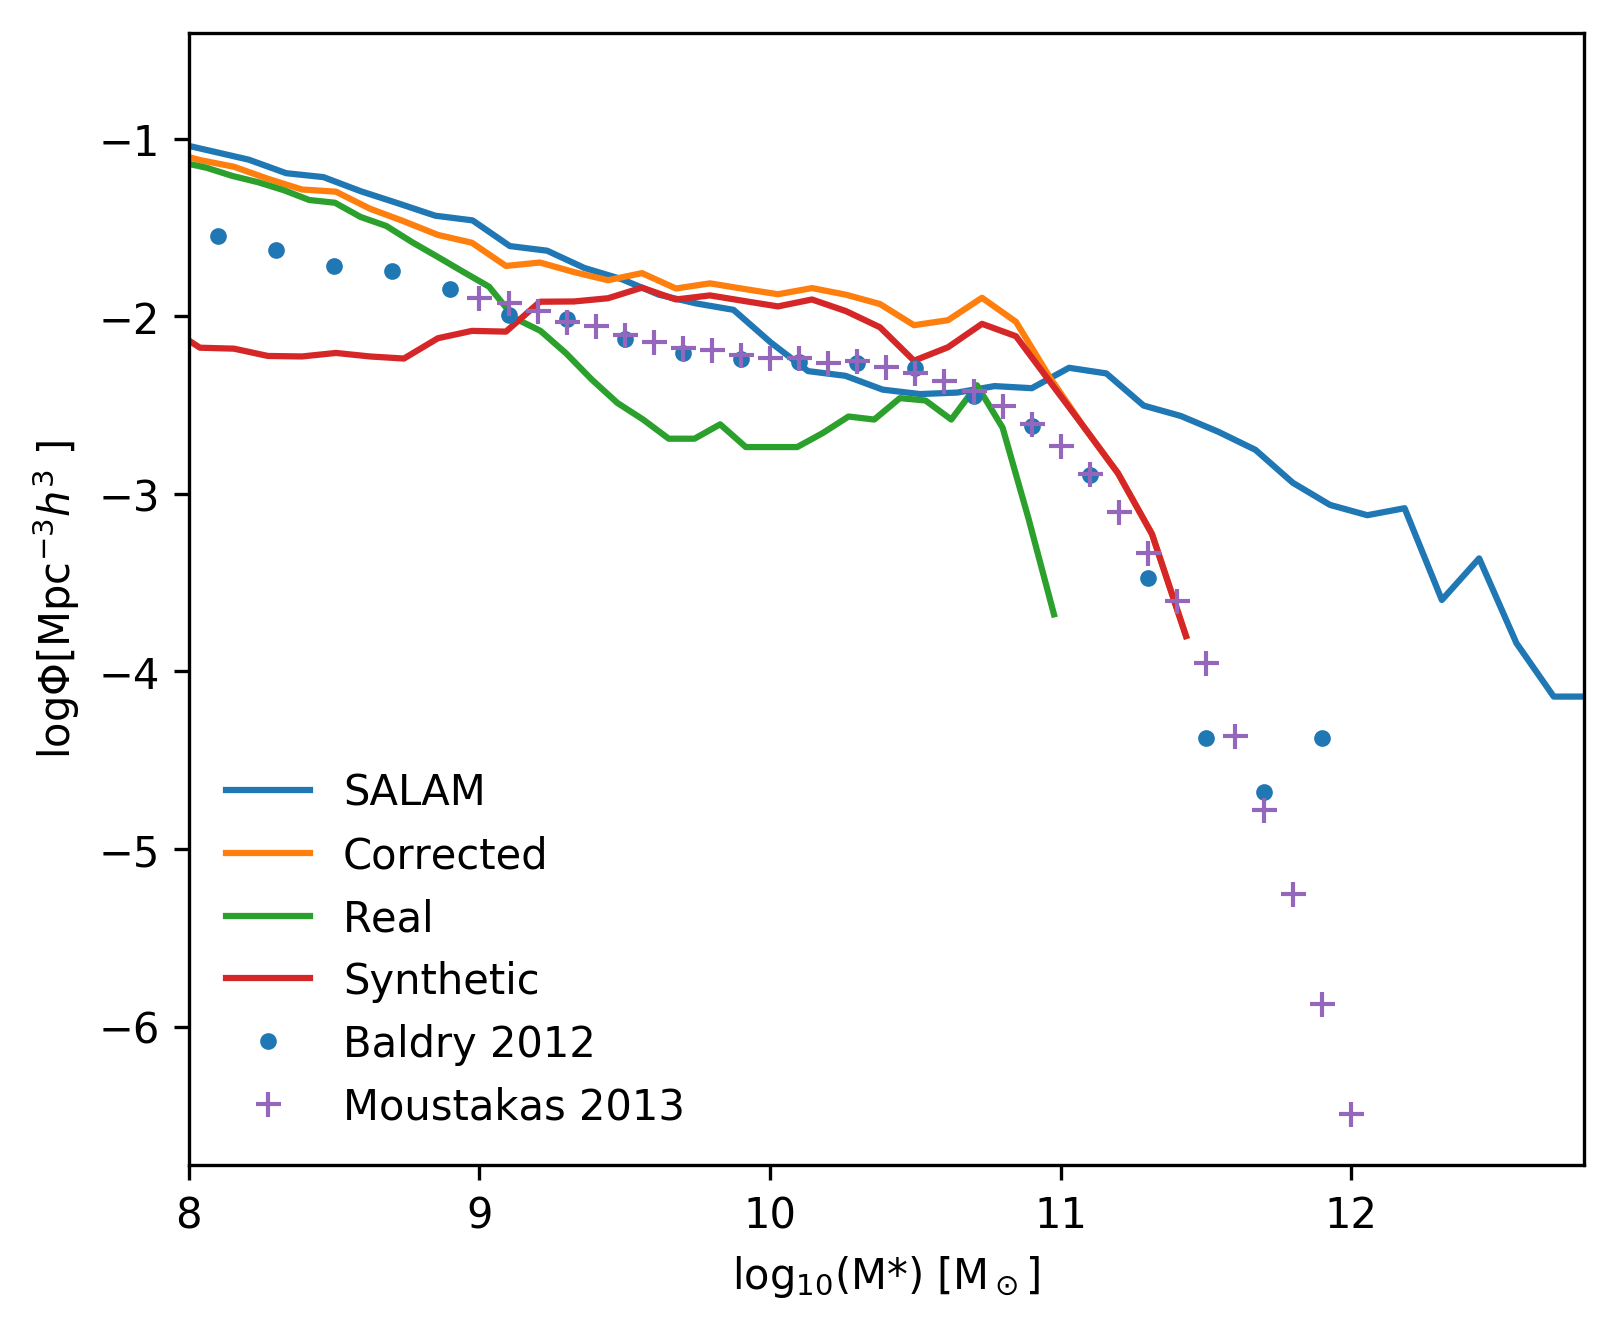

In [54]:
# ---------------------------------
# ----- STELLAR MASS FUNCTION -----
# ---------------------------------
def plotSMF(entry, size, label):
    mstar = plot_tools.filter_list(entry['mstar'], 1e-5, 1e20)
    logM = np.log10(mstar)
    nbins = 50
    V = size**3
    Phi, edg = np.histogram(logM, bins=nbins)    #Unnormalized histogram and bin edges
    dM = edg[1] - edg[0]
    Max = np.array(edg[0:-1]) + dM/2
    Phi = Phi/V/dM
    ax.plot(Max, np.log10(Phi), label=label)
    ax.fill_between(Max, np.log10(Phi + np.sqrt(Phi)), np.log10(Phi - np.sqrt(Phi)))

both = {
    'mstar': np.concatenate((entryReal['mstar'], entryFalse['mstar'])),
    'sfr_10': np.concatenate((entryReal['sfr_10'], entryFalse['sfr_10']))
}

fig, ax = plt.subplots(figsize=(6,5), dpi = 300)

plotSMF(entry, 60, 'SALAM')
plotSMF(both, 60, 'Corrected')
plotSMF(entryReal, 60, 'Real')
plotSMF(entryFalse, 60, 'Synthetic')

# Redshift z = 0.2
baldry = np.genfromtxt('obs/Baldry_2012_SMF_z0.csv',unpack=True,skip_header=1,delimiter=',')
moustakas = np.genfromtxt('obs/Moustakas_2013_SMF_z0.csv', unpack=True, skip_header=1, delimiter=',')
ax.plot(baldry[0], np.log10(baldry[1]*10e-4), marker = '.', label='Baldry 2012', linestyle='None', color = 'tab:blue')
ax.plot(moustakas[0], moustakas[1], marker = '+', label='Moustakas 2013', linestyle='None', color = 'tab:purple')
ax.errorbar(baldry[0], np.log10(baldry[1]), fmt='none')

# Plot parameters
ax.set_ylabel(r'$\mathrm{log}\Phi [\mathrm{Mpc}^{-3} h^3$ ]')
ax.set_xlabel('log$_{10}$(M*) [M$_\odot$]')
ax.set_xlim(8, 12.8)
ax.legend(frameon=False)


/home/hc2347/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log10


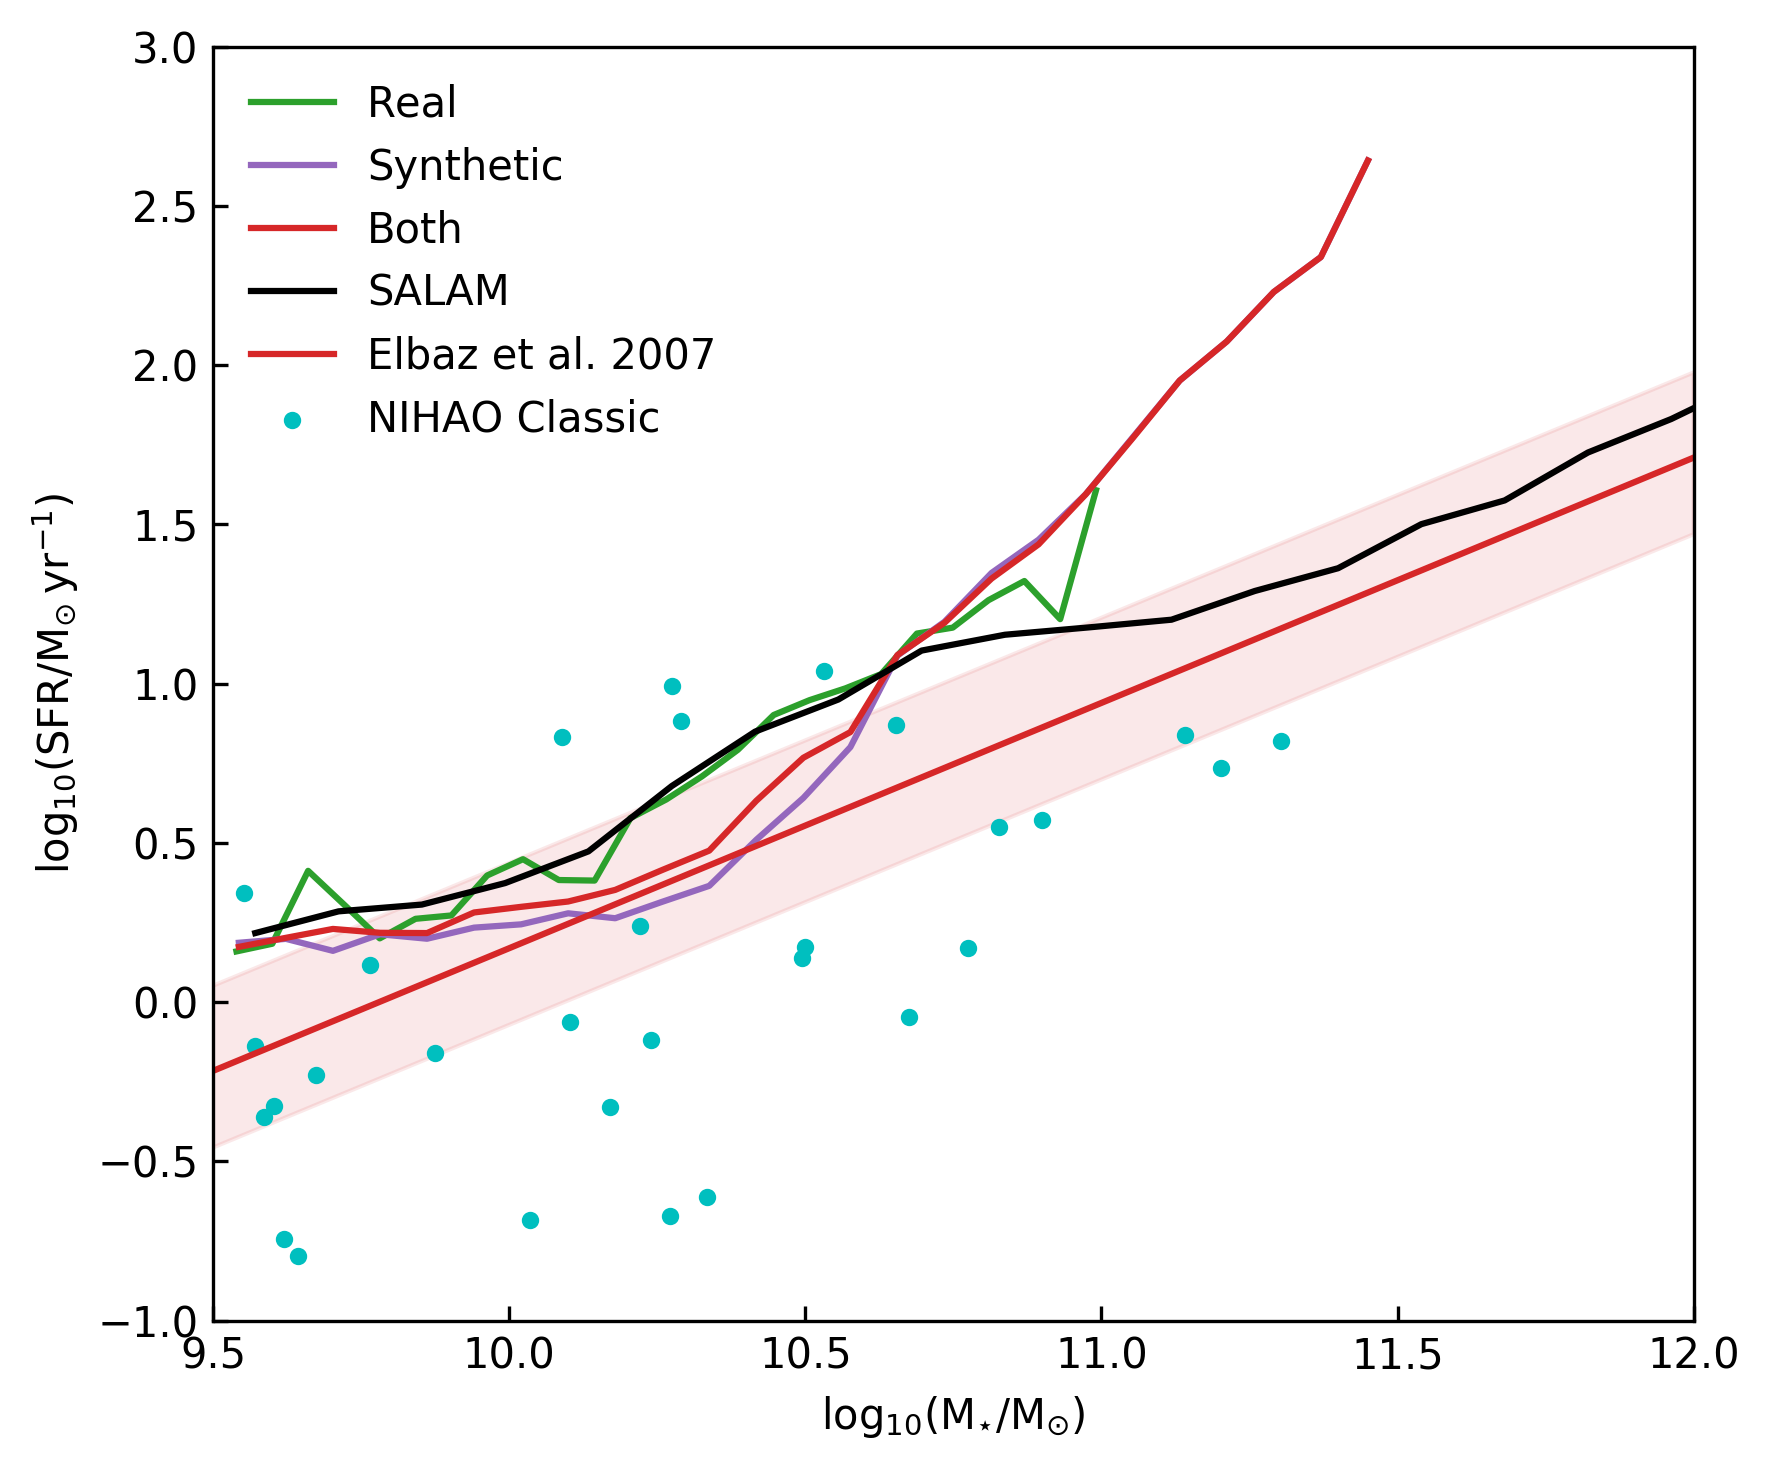

In [44]:
# ----------------------------------------------
# --------- STAR FORMATION RATE ----------------
# ----------------------------------------------

def plotSFR(entry, color, label):
    x, y = do_filter(entry['mstar'], entry['sfr_10'])
    
    for i in range(len(x) - 1, -1, -1):
        if x[i] < 10**9.5:
            x = np.delete(x, i)
            y = np.delete(y, i)
    
    x, y, s = bin_stats(np.log10(x), np.log10(y))
    ax.plot(x, y, c = color, label = label)
    #ax.fill_between(x, y + s, y - s, color = color, alpha = 0.2)

def elbaz_sdss(logmstar):
    fit = lambda x: np.log10(x*(10**(logmstar-11))**0.77)
    return fit(8.7), fit(8.7+7.4), fit(8.7-3.7)

def noeske(logmstar):
    fit = lambda x, y: x*logmstar - y
    return fit(0.67, 6.19), fit(0.67+ 0.08, 6.19+0.78), fit(0.67 - 0.08, 6.19 - 0.78)

fig, ax = plt.subplots(figsize=(6,5), dpi=300)

# SALAM Classified
plotSFR(entryReal, "tab:green", "Real")
plotSFR(entryFalse, "tab:purple", "Synthetic" )

# Both
plotSFR(both, "tab:red", "Both")

# SALAM Original
plotSFR(entry, "black", "SALAM")

# Add observations
# noy, noyu, noyd = noeske(np.linspace(10,11))
# ax.plot(np.linspace(10, 11), noy, color = "tab:orange", label="Noeske et al. 2007")
# ax.fill_between(np.linspace(10,11), noyu, noyd, color = "tab:orange", alpha = 0.5)

elbazy, elbazyup, elbazyd = elbaz_sdss(np.linspace(9,12))
ax.plot(np.linspace(9, 12), elbazy, color = "tab:red", label = "Elbaz et al. 2007")
ax.fill_between(np.linspace(9,12), elbazyup, elbazyd, color = "tab:red", alpha = 0.1)

# Add NIHAO
nihao_x = plot_tools.nihao('mstar',0)
nihao_y = plot_tools.nihao('sfr_10',0)
ax.scatter(np.log10(nihao_x), np.log10(nihao_y), 10, color='c', label="NIHAO Classic")

# Plot parameters
xlabel = '$\\rm{log_{10}}(M_{\star}/\\rm M_{\odot})$'
ylabel = '$\\rm{log_{10}(SFR/M_{\odot}\,yr^{-1})}$'

ax.set(xlabel=xlabel, ylabel=ylabel, xlim = [9.5, 12], ylim = [-1,3])
ax.legend(frameon=False)
ax.tick_params(direction='in', which='both')
plt.tight_layout()


/home/hc2347/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10


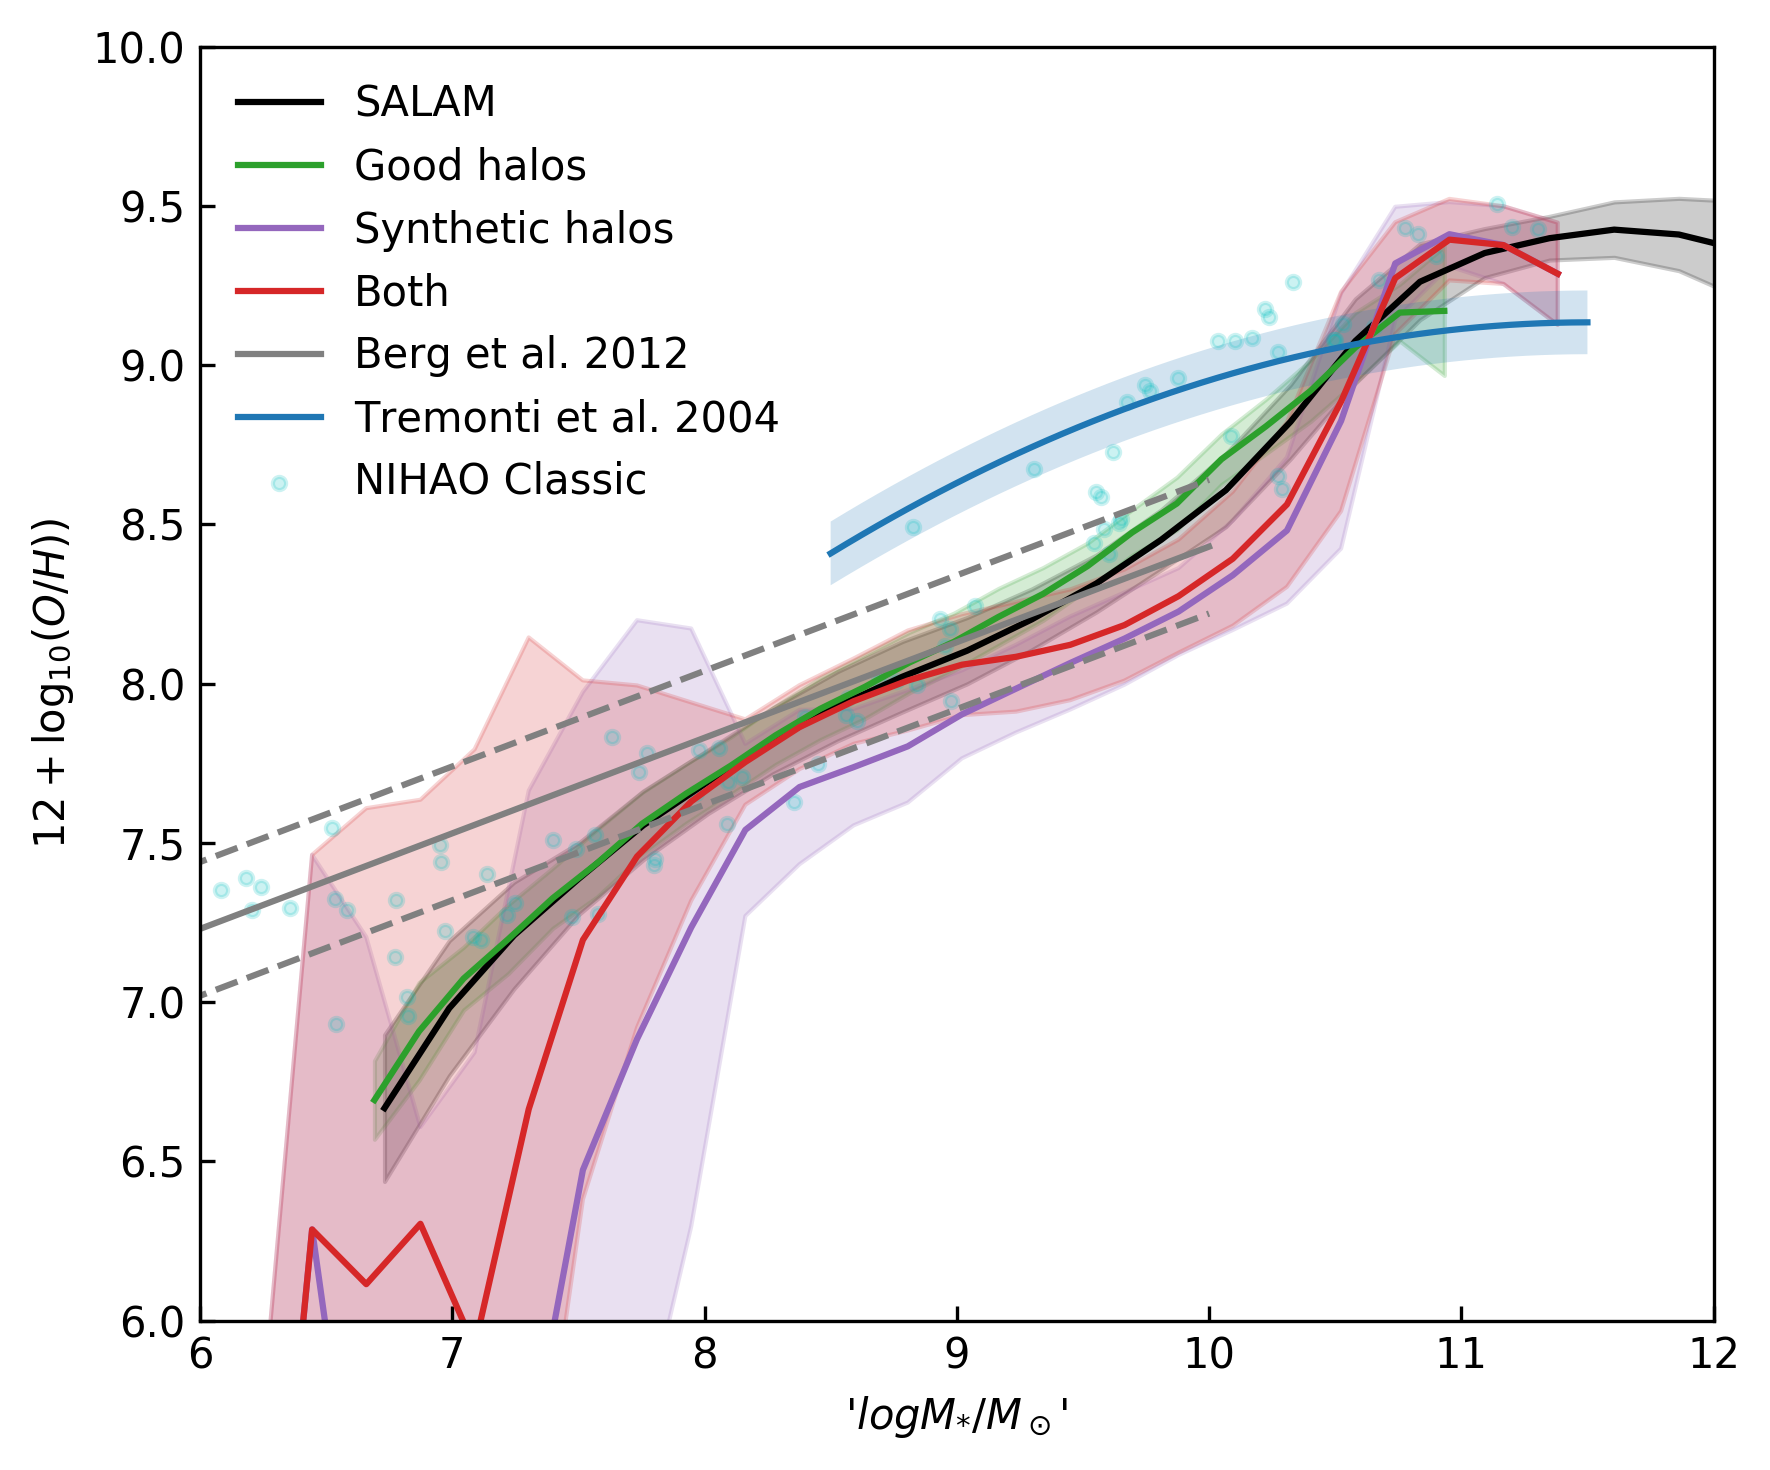

In [49]:
# OXYGEN ABUNDANCE

def BergMZR(logmstar):
    oxh = 5.43 + 0.30*logmstar
    return oxh

def TremontiFit(logmstar):
    # Valid over the range 8.5 to 11.5
    return - 1.492 + 1.847*logmstar - 0.08026*(logmstar**2)

def plotoxh(entry, color, label):
    x = entry["mstar"]
    values = entry["oxh"]
    x, values = do_filter(np.log10(np.array(x, dtype=float)), np.array(values, dtype=float), 1e-5)
    ci, mi, si = bin_stats(x, values)
    ax.plot(ci, mi, color=color, label = label)
    ax.fill_between(ci, mi+si, mi-si, color = color, alpha = 0.2)


fig, ax = plt.subplots(figsize=(6,5), dpi = 300)

# SALAM
plotoxh(entry, 'black', 'SALAM')
plotoxh(entryReal, 'tab:green', 'Good halos')
plotoxh(entryFalse, 'tab:purple', 'Synthetic halos')

both['oxh'] = np.concatenate((entryReal['oxh'], entryFalse['oxh']))
plotoxh(both, 'tab:red', 'Both')

# Berg
ax.plot(np.linspace(5, 10), BergMZR(np.linspace(5, 10)), color = "grey", label = "Berg et al. 2012")
ax.plot(np.linspace(5, 10), BergMZR(np.linspace(5, 10)) + 0.21, color = "grey", linestyle = "--")
ax.plot(np.linspace(5, 10), BergMZR(np.linspace(5, 10)) - 0.21, color = "grey", linestyle = "--")

# Tremonti
tremontiy = TremontiFit(np.linspace(8.5, 11.5))
ax.plot(np.linspace(8.5,11.5), tremontiy, label = "Tremonti et al. 2004")
ax.fill_between(np.linspace(8.5, 11.5), tremontiy+0.1, tremontiy-0.1, alpha = 0.2)

# NIHAO
nihao_x = plot_tools.nihao('mstar',0)
nihao_y = plot_tools.nihao('oxh',0)
ax.scatter(np.log10(nihao_x), nihao_y, 10, color='c', label = "NIHAO Classic", alpha = 0.2)

# Plot Parameters
ax.axis([6, 12, 6, 10])
ax.set(xlabel = "'$ log M_{*}/M_\odot$'", ylabel = '$12+\log_{10}(O/H))$')
ax.legend(frameon=False)
ax.tick_params(direction='in', which='both')
plt.tight_layout()
